### Importing the required libraries

<b>Situation:</b> Using the CNN's I am trying to do a classification of Medical Reports.

In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from PIL import Image
from torch.utils.data import DataLoader, random_split, Dataset
from torch.utils.data import Dataset
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score

In [2]:
device = "cpu" if (torch.cuda.is_available()) else "cpu"
print("Using ", device, " device")

Using  cpu  device


### Data Augumentation:

Data Augumentation is an important step in improving the generalization capabilities and accuracy of the CNN model. It helps model to learn robust unique details/features in the image. 

Some of the Augumentation methods I uses:

<b>RandomHorizontalFlip:</b> As the name suggest, it flips the image on random basis.

<b>RandomVerticalFlip:</b> Randomly flips the images vertically. 

<b>RandomRotation:</b> Randomly rotates the images with a certain angle.

<b>ColorJitter:</b>  As names says, it changes the color characteristics, brightness, contrast, saturation and hue of the image with given values.

<b>RandomGrayScale</b> It converts the color image to grayscale image.

There are several Augumentation techniques, which improves the efficiency of the model. 
Here a quick link: [link](https://mxnet.apache.org/versions/1.2.1/tutorials/python/types_of_data_augmentation.html)



In [3]:
# Declaring the transform for each image (Convert to Tensor and Normalize)
# In normalization we are performing Zscore-Normalization.
# In ZscoreN, we take the std and mean of the entire dataset. We subtract each pixel in the image with the mean and divide by std.
# This way we ensure that feature of the images are more comparable and can improve the model learning.
# We used the mean and std of ImageNet as we are using it's pretrained weights for the training.
trans = [
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomVerticalFlip(), 
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale()
]

toTensor = transforms.Compose([
    transforms.RandomApply(trans, p=0.8),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Custom Dataset Declaration

In [6]:
# Based on the rootDir, loading 1000 images from each class

class customDataset(Dataset):
    def __init__(self, rootDir, toTensor, numPerClass):
        self.datasetDir = rootDir
        self.numPerClass = numPerClass
        self.transform = toTensor
        self.classes = os.listdir(rootDir)
        self.imagePath = []
        self.labels = []
        for classIdx, className in enumerate(self.classes):
            classPath = os.path.join(rootDir, className)
            imagesList = os.listdir(classPath)
            random.shuffle(imagesList)
            for idx in range(0, numPerClass):
                self.imagePath.append(os.path.join(classPath, imagesList[idx]))
                self.labels.append(classIdx)
        
    def __getitem__(self, index: int):
        cv2Image = cv2.imread(self.imagePath[index])
        pilImage = Image.fromarray(cv2Image)
        image = self.transform(pilImage)
        label = self.labels[index]
        label_tensor = torch.tensor(label)
        return image, label_tensor

    def __len__(self):
        return len(self.imagePath)
    
    def displayImages(self):
        fig, axes = plt.subplots(2, len(self.classes), figsize=(12,12))
        
        for classIdx, className in enumerate(self.classes):
            imageIdx = np.random.randint(low=0, high=len(self.labels) - 1)
            classPath = os.path.join(self.datasetDir, className)
            finalImagePath = os.path.join(classPath, os.listdir(classPath)[imageIdx])
            
            cv2Image = cv2.imread(finalImagePath)
            pilImage = Image.fromarray(cv2Image)
 
            # Apply transforms
            transformedImage = self.transform(pilImage)
            
            # Convert transformed image to PIL image
            pilTransformedImage = transforms.ToPILImage()(transformedImage)
            
            # Convert PIL image to NumPy array for display
            augumentedImage = np.array(pilTransformedImage)
            
            axes[0, classIdx].imshow(pilImage)
            axes[0, classIdx].set_title(className)
            axes[0, classIdx].axis('off')

            axes[1, classIdx].imshow(augumentedImage)
            axes[1, classIdx].set_title("Augumented" + className)
            axes[1, classIdx].axis('off')
        
        plt.tight_layout()
        plt.show()

In [7]:
#Declaring the Root directory to get the MNIst dataset from google drive
rootDir = 'MedNIST_dataset'

#Creating a Class Object of CustomDataset
Dataset = customDataset(rootDir, toTensor, 1000)

['HeadCT', 'Hand', 'CXR', 'AbdomenCT', 'ChestCT', 'BreastMRI']


### Displaying images retrived from Custom Dataset.

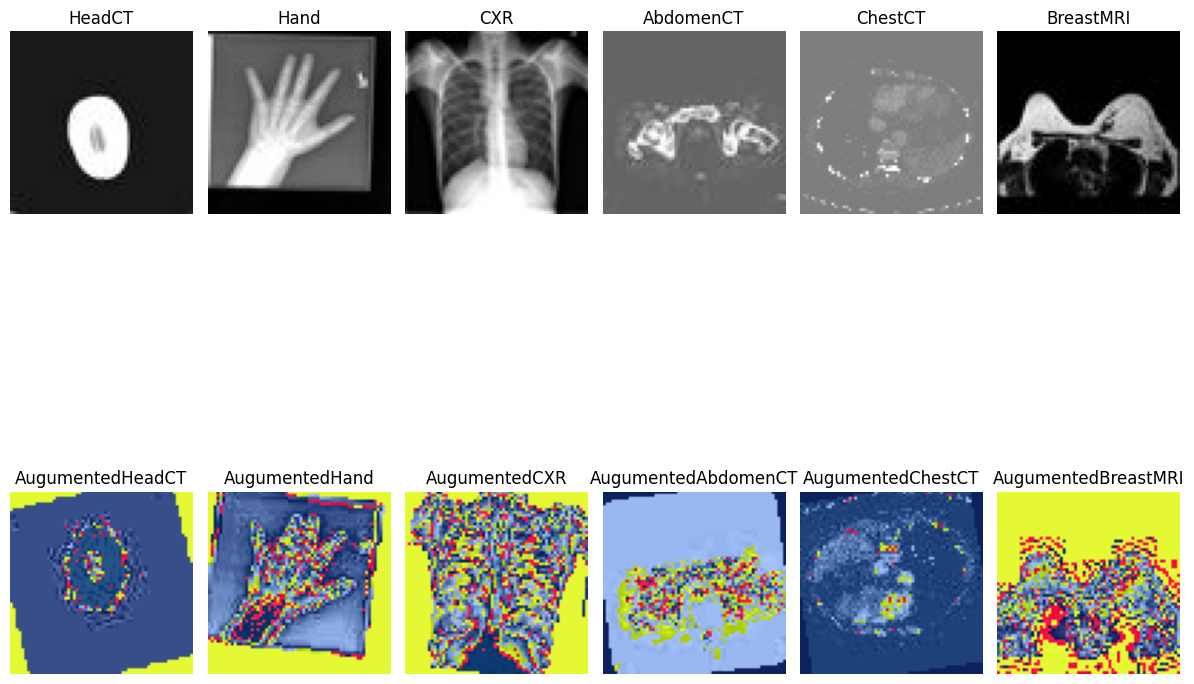

In [8]:
#Displaying the Images
Dataset.displayImages()

### Model Hyper-parameters

In [9]:
#Declaring hyper-parameters
numClasses = 6
learningRate = 0.0001
numEpochs = 10
batchSize = 256

### Dataloader Declaration

In [10]:
# Splitting data in train and test
trainDataSize = int(Dataset.__len__()*0.7)
testDataSize = int(Dataset.__len__()*0.2)
valDataSize = Dataset.__len__() - trainDataSize -  testDataSize
trainData, testData, valData = random_split(Dataset, [trainDataSize, testDataSize, valDataSize])

#Declaring the Dataloaders for train and test.
trainDataLoader = DataLoader(trainData, batch_size = batchSize,  shuffle = True)
testDataLoader = DataLoader(testData, batch_size = batchSize,  shuffle = True)
valDataLoader = DataLoader(valData, batch_size=batchSize, shuffle=True)

### Check if any data samples are in common in train, validation and test data splits

In [11]:
def extract_filenames(dataset):
    filenames = set()
    original_dataset = dataset.dataset
    for idx in range(len(dataset)):
        filenames.add(original_dataset.imagePath[dataset.indices[idx]])
    return filenames


def compare_filenames(loader1, loader2):
    dataset1 = loader1.dataset
    dataset2 = loader2.dataset
    
    filenames1 = extract_filenames(dataset1)
    filenames2 = extract_filenames(dataset2)
    
    common_filenames = filenames1.intersection(filenames2)
    unique_filenames_loader1 = filenames1.difference(filenames2)
    unique_filenames_loader2 = filenames2.difference(filenames1)
    
    return common_filenames, unique_filenames_loader1, unique_filenames_loader2

# Example usage
common_filenames, unique_filenames_train, unique_filenames_val = compare_filenames(trainDataLoader, valDataLoader)
print("Common filenames between train and val:", len(common_filenames))

common_filenames, unique_filenames_train, unique_filenames_val = compare_filenames(testDataLoader, valDataLoader)
print("Common filenames between test and val:", len(common_filenames))

common_filenames, unique_filenames_train, unique_filenames_val = compare_filenames(trainDataLoader, testDataLoader)
print("Common filenames between train and test:", len(common_filenames))



Common filenames between train and val: 0
Common filenames between test and val: 0
Common filenames between train and test: 0


### Model class declaration:

In [12]:
#Declaring Custom Network based on the instructions
class CustomNetwork(torch.nn.Module):
    def __init__(self, dropout_rate=0.7):
        super(CustomNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1) #Conv Layer --> 64 x 64 x 32
        self.relu1 = nn.ReLU() #Relu Layer
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #MaxPool layer --> 32 x 32 x 32
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) #Conv layer ---> 32 x 30 x 30
        self.relu2 = nn.ReLU() #Relu Layer
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  #MaxPool layer ---> 32 x 16 x 16
        self.fc1 = nn.Linear(64*16*16, 128) #FC Layer
        self.relu3 = nn.ReLU() #Relu Layer
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(128, 64) #FC Layer
        self.relu4 = nn.ReLU() #Relu Layer
        self.fc3 = nn.Linear(64, 6) #FC Layer
        self.softmax = nn.Softmax(dim=1) #Softmax to calcuate the probabilities

    def forward(self, inputImage):
        #Creating the network forward method
        x = self.conv1(inputImage)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [13]:
#Declaring the model object from created custom network class
model = CustomNetwork()
print(model) #Priting the model

CustomNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.7, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=64, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)


### Train Loop

In [14]:
model.to(device)
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learningRate)

trainLossList = []
trainAccuracyList = []
valLossList = []
valAccuracyList = []

for epoch in range(numEpochs):
    model.train()
    totalTrainLoss = 0.0
    totalTrainAcc = 0.0
    totalValAcc = 0.0
    correctTrainPredictions = 0
    totalSamples = 0
    acc = 0
    for i, (trainImages, trainLabels) in enumerate(trainDataLoader):
        #print(images.shape)
        trainImages = trainImages.to(device)
        trainLabels = trainLabels.to(device)

        # Forward Pass
        trainOutput = model(trainImages)
        trainLoss = criteria(trainOutput, trainLabels)
        
        # Backward Propagation
        optimizer.zero_grad()
        trainLoss.backward()
        optimizer.step()
        totalTrainLoss += trainLoss.item()
        
        # Calculating the accuracy
        _, predLabels = torch.max(trainOutput, 1)

        # Calulating the number of correct predictions in a batch
        predLabels_np = predLabels.cpu().numpy()
        trainLabels_np = trainLabels.cpu().numpy()
        totalTrainAcc += accuracy_score(trainLabels_np, predLabels_np)

    #trainAccuracyList.append(correctTrainPredictions/totalSamples)
    trainAccuracyList.append(totalTrainAcc/ len(trainDataLoader))
    trainLossList.append(totalTrainLoss/len(trainDataLoader))
    
    correctValPredictions = 0
    totalSamples = 0

    for i, (valImages, valLabels) in enumerate(valDataLoader):
        valImages = valImages.to(device)
        valLabels = valLabels.to(device)

        totalValLoss = 0.0
        model.eval()
        with torch.no_grad():
            valOutput = model(valImages)
            valLoss = criteria(valOutput, valLabels)
            totalValLoss += valLoss.item()

            # Calculating the accuracy
            _, predLabels = torch.max(valOutput, 1)
            
            # Calulating the number of correct predictions in a batch
            predLabels_np = predLabels.cpu().numpy()
            valLabels_np = valLabels.cpu().numpy()
            totalValAcc += accuracy_score(valLabels_np, predLabels_np)
            
    valAccuracyList.append(totalValAcc/len(valDataLoader))  
    valLossList.append(totalValLoss/len(valDataLoader))
    
    print(f'Epoch [{epoch+1}/{numEpochs}], Train Loss: {trainLossList[-1]:.4f}, Val Loss: {valLossList[-1]:.4f}, Train Accuracy: {trainAccuracyList[-1]:.4f}, Val Accuracy: {valAccuracyList[-1]: .4f}')
         
    

Epoch [1/10], Train Loss: 1.7129, Val Loss: 0.5227, Train Accuracy: 0.4153, Val Accuracy:  0.4588
Epoch [2/10], Train Loss: 1.5300, Val Loss: 0.4571, Train Accuracy: 0.5474, Val Accuracy:  0.7721
Epoch [3/10], Train Loss: 1.3940, Val Loss: 0.4187, Train Accuracy: 0.7263, Val Accuracy:  0.8581
Epoch [4/10], Train Loss: 1.2942, Val Loss: 0.4014, Train Accuracy: 0.8111, Val Accuracy:  0.8776
Epoch [5/10], Train Loss: 1.2441, Val Loss: 0.3752, Train Accuracy: 0.8422, Val Accuracy:  0.9251
Epoch [6/10], Train Loss: 1.1971, Val Loss: 0.3701, Train Accuracy: 0.8807, Val Accuracy:  0.9250
Epoch [7/10], Train Loss: 1.1780, Val Loss: 0.3664, Train Accuracy: 0.8961, Val Accuracy:  0.9289
Epoch [8/10], Train Loss: 1.1633, Val Loss: 0.3851, Train Accuracy: 0.9006, Val Accuracy:  0.9192
Epoch [9/10], Train Loss: 1.1492, Val Loss: 0.3764, Train Accuracy: 0.9158, Val Accuracy:  0.9266
Epoch [10/10], Train Loss: 1.1407, Val Loss: 0.3708, Train Accuracy: 0.9191, Val Accuracy:  0.9329


### Display the train/Validation training graphs

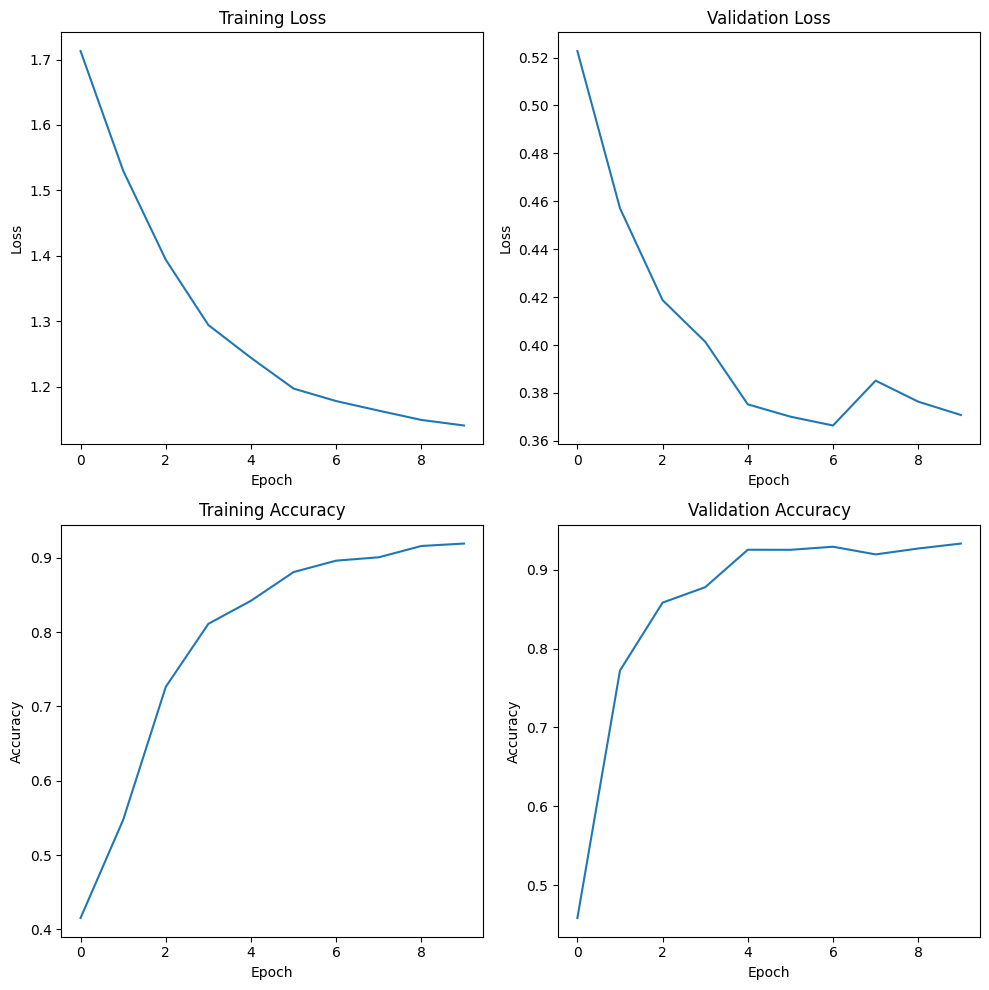

In [15]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))

axes[0, 0].plot(trainLossList)
axes[0, 0].set_title("Training Loss")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")

axes[0, 1].plot(valLossList)
axes[0, 1].set_title("Validation Loss")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Loss")

axes[1, 0].plot(trainAccuracyList)
axes[1, 0].set_title("Training Accuracy")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Accuracy")

axes[1, 1].plot(valAccuracyList)
axes[1, 1].set_title("Validation Accuracy")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Accuracy")

plt.tight_layout()


### Inference testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


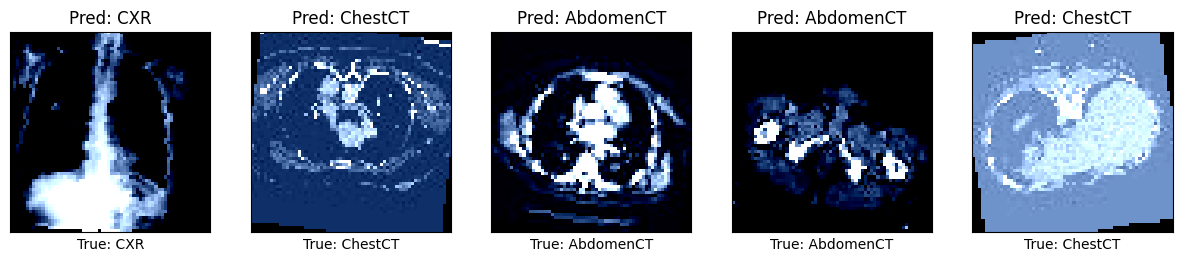

In [16]:
model.eval()
testLossList = []
testAccuracyList = []
testPredictionsList = []
testTrueLabelsList = []

# Set the number of examples to print
num_examples = 5

with torch.no_grad():
    for i, (testImages, testLabels) in enumerate(testDataLoader):
        testImages = testImages.to(device)
        testLabels = testLabels.to(device)

        testOutput = model(testImages)
        testLoss = criteria(testOutput, testLabels)
        testLossList.append(testLoss.item())

        _, predLabels = torch.max(testOutput, 1)

        # Calulating the number of correct predictions in a batch
        testAccuracyList.append(accuracy_score(testLabels, predLabels))

        # Collect predictions and true labels for computing precision, recall, and F1
        testPredictionsList.extend(predLabels.cpu().numpy())
        testTrueLabelsList.extend(testLabels.cpu().numpy())

        # Print labels and images for a few examples
        if i == 0:  # Print only for the first batch
            fig, axes = plt.subplots(1, num_examples, figsize=(15, 15))
            label_names = ['HeadCT', 'Hand', 'CXR', 'AbdomenCT', 'ChestCT', 'BreastMRI']
            for j in range(num_examples):
                axes[j].imshow(np.transpose(testImages[j].cpu().numpy(), (1, 2, 0)))
                axes[j].set_xlabel(f'True: {label_names[testLabels[j].item()]}')
                axes[j].set_title(f'Pred: {label_names[predLabels[j].item()]}')
                axes[j].set_xticks([])
                axes[j].set_yticks([])
            plt.show()

# Calculate average test loss and accuracy
avgTestLoss = sum(testLossList) / len(testLossList)
avgTestAccuracy = sum(testAccuracyList) / len(testAccuracyList)

### Results

In [17]:
# Compute Precision, confusionMatrix, F1 and recall
precision = precision_score(testTrueLabelsList, testPredictionsList, average="weighted")
recall = recall_score(testTrueLabelsList, testPredictionsList, average="weighted")
f1 = f1_score(testTrueLabelsList, testPredictionsList, average="weighted")
confusionMat = confusion_matrix(testTrueLabelsList, testPredictionsList)

print(f'Test Accuracy: {avgTestAccuracy:.4f}')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
print(f'Confusion matrix:')
print(confusionMat)

Test Accuracy: 0.9518
Precision: 0.9513, Recall: 0.9508, F1 Score: 0.9505
Confusion matrix:
[[155   5   0   0   0  11]
 [  6 201   6   0   1   1]
 [  1   5 211   0   1   0]
 [  0   0   0 186   4   0]
 [  0   0   2  16 163   0]
 [  0   0   0   0   0 225]]
